# Análise de Retenção de Clientes com Regressão Logística

**Tarefa 5 da disciplina Análise Estatística de Dados e Informações, ministrada por João Gabriel de Moraes Souza**

**Aluno**: Adam Victor Nazareth Brandizzi

## Introdução

A retenção de clientes é um termo que refere-se tanto a uma métirca que avaialia quantos clientes permanecem ligados a uma instituição quanto procedimentos tomados para manter ou incrementar esta métrica. Isto ocorre porque o processo de aquisição de clientes é geralmente muito mais caro que a manutenção, e uma alta evasão (comumente chamada *churn*) pode indicar problemas fundamentais em uma empresa.

Neste trabalho, avaliaremos as estatísticas de clientes de uma instituição bancária, tentando identificar que fatores podem levar a uma evasão maior ou menor. Para isto, vamos utilizar a base [Predicting Churn for Bank Customers](https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers?resource=download).

## Análise exploratória inicial

In [1]:
import pandas as pd
df = pd.read_csv('./Churn_Modelling.csv')
df.infer_objects(copy=False)
pd.DataFrame(dict(columns=df.columns))

,columns
0,RowNumber
1,CustomerId
2,Surname
3,CreditScore
4,Geography
5,Gender
6,Age
7,Tenure
8,Balance
9,NumOfProducts


As colunas `RowNumber`, `CustomerId` e `Surname` podem, razoavelmente, ser descartadas sem grande análise: não esperamos que o nome ou o identificador (arbitrário) do cliente acrescentaria muita informação. A coluna `Exited` contém a variável dependente que desejamos prever, e as demais, as variáveis independentes (i.e. fatores) que temos disponíveis.

In [2]:
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1).copy()
Y = df['Exited'].astype(int).copy()
factors = X.columns
output_column = Y.name
relevant_columns = list(factors) + [output_column]

Vale a pena observar se as colunas possuem valores nulos (i.e.  `nan`, `null` etc.) como valores:

In [3]:
pd.DataFrame({
    'factor': relevant_columns,
    'null': [df[c].isnull().any() for c in relevant_columns]
})


,factor,null
0,CreditScore,False
1,Geography,False
2,Gender,False
3,Age,False
4,Tenure,False
5,Balance,False
6,NumOfProducts,False
7,HasCrCard,False
8,IsActiveMember,False
9,EstimatedSalary,False


Felizmente, todas as linhas estão com suas colunas propriamente preenchidas.

Note que, dos fatores restantes, dois são categóricos:  `Geography` e `Gender`. Vamos tomar nota, pois eventualmente teremos de codificá-los em valores numéricos.


In [4]:
categorical_factors = ['Geography', 'Gender']
numeric_factors = [f for f in X.columns if f not in categorical_factors and f != 'const']
X_raw = X
X = pd.get_dummies(X, columns=categorical_factors, drop_first=True, dtype=int)

Façamos então uma breve análise exploratória de cada fator.

## `Geography`

Os clientes vêm de locais diferentes. Estas são as localições encontradas na base:

In [5]:
import plotly.express as px

def count_exited(X, Y, factor):
    counting = pd.DataFrame(X[factor].value_counts())
    counting['Exited'] = [
        sum(Y[X[factor] == c]) for c in counting.index
    ]
    counting["Stayed"] = counting.iloc[:, 0] - counting["Exited"]
    counting["Exited%"] = counting["Exited"] / counting.iloc[:, 0]
    counting["Stayed%"] = counting["Stayed"] / counting.iloc[:, 0]
    return counting

def plot_counting(title, counting, format='bar'):  
    factor_name = counting.index.name or 'Value'
    title = f"Proportion of Exited vs Stayed by {factor_name}"
    
    df = counting.reset_index().melt(
        id_vars=factor_name,
        value_vars=["Exited%", "Stayed%"],
        var_name="Status",
        value_name="Proportion"
    )

    fig = None
    if format == 'bar':
        fig = px.bar(
            df,
            x=factor_name,
            y="Proportion",
            color="Status",
            title=title,
            text=df["Proportion"].apply(lambda x: f"{x:.0%}"),
        )
    elif format == 'area':
        fig = px.area(
            df,
            x=counting.index.name or "Value",
            y="Proportion",
            color="Status",
            title=title,
        )
        
    fig.update_layout(
        yaxis=dict(title=title, tickformat=".0%"),
        xaxis_title=factor_name,
        legend_title="Status",
        hovermode="x unified",
        height=500,
    )

    fig.show()
    return counting
    

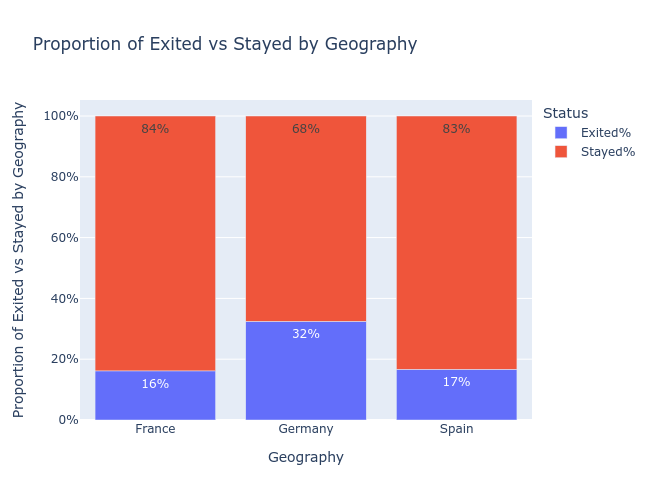

,count,Exited,Stayed,Exited%,Stayed%
Geography,,,,,
France,5014,810,4204,0.161548,0.838452
Germany,2509,814,1695,0.324432,0.675568
Spain,2477,413,2064,0.166734,0.833266


In [6]:
geography_counting = count_exited(X_raw, Y, 'Geography')

plot_counting('Proporção de churn por país', geography_counting)

O fato de haver um churn maior na Alemanha indica que essa propriedade pode ter informações importantes para previsão.

## Gender

No que tange a gênero, notamos que mulheres tendem a fechar suas contas mais que homens proporcionalmente falando.

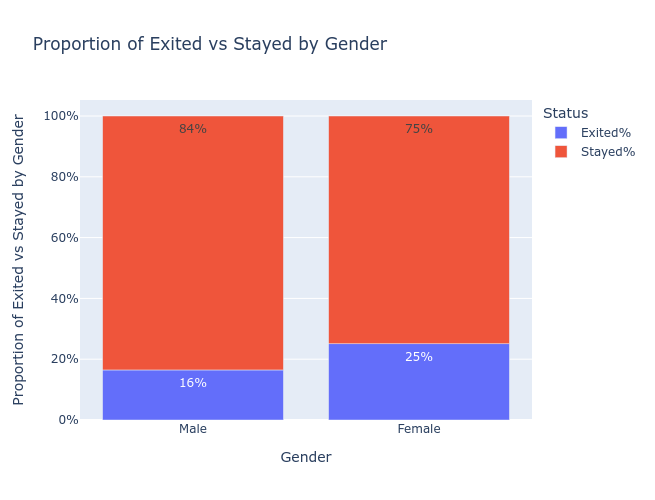

,count,Exited,Stayed,Exited%,Stayed%
Gender,,,,,
Male,5457,898,4559,0.164559,0.835441
Female,4543,1139,3404,0.250715,0.749285


In [7]:
gender_counting = count_exited(X_raw, Y, 'Gender')
plot_counting('Proporção de churn por gênero', gender_counting)

## Age



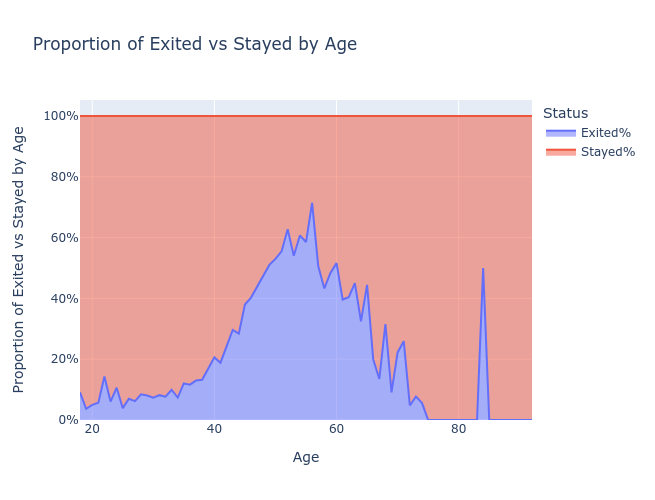

In [8]:
age_counting = count_exited(X_raw, Y, 'Age')
_ = plot_counting('Proporção de churn por idade', age_counting, format='area')

Notamos que a proporção tende a ter uma forma normal ligeiramente viesada para a esquerda, exceto por um pico outlier causado na idade de 84 anos, quando há apenas dois clientes, e um deles saiu:

In [9]:
X_raw[X_raw['Age']==84]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3387,537,Germany,Male,84,8,92242.34,1,1,1,186235.98
3531,408,France,Female,84,8,87873.39,1,0,0,188484.52


Como o outlier afeta a regressão? Vamos fazer um teste de regressão logística com e sem outlier:

In [10]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import textwrap


def compare_models(X, Y, X_prime, Y_prime):
    full_model = sm.Logit(Y, X).fit(disp=False)
    alternative_model = sm.Logit(Y_prime, X_prime).fit(disp=False)

    print(
        'Full dataset:', full_model.params,
        'Alt dataset:', alternative_model.params,
        sep='\n'
    )

    full_prediction = full_model.predict(X)
    alternative_prediction = alternative_model.predict(X_prime)
    print("AUC full:", roc_auc_score(Y, full_prediction))
    print("AUC alt:", roc_auc_score(Y_prime, alternative_prediction))
    return full_model, alternative_model

def compare_outlier(X, Y, factor, outliers):
    F = sm.add_constant(X[factor])
    full_model = sm.Logit(Y, F).fit(disp=False)

    F_prime = F[~(F[factor].isin(outliers))]
    Y_prime = Y[~(F[factor].isin(outliers))]
    return compare_models(F, Y, F_prime, Y_prime)


_ = compare_outlier(X, Y, 'Age', outliers=[84])

Full dataset:
const   -3.928603
Age      0.062945
dtype: float64
Alt dataset:
const   -3.934058
Age      0.063084
dtype: float64
AUC full: 0.7320707498986938
AUC alt: 0.7320313606526877


O outlier claramente não afetou drasticamente o modelo, de modo que acreditamos não ser necessário removê-lo.

## Tenure

Antes de investigarmos o tempo de conta ("tenure"), vamos verificar um ponto importante. Idade e tempo de conta têm o potencial de terem alta colinearidade. Como são apenas dois valores, demos verificar isso de maneira simples, observando a matriz de correlação:

In [11]:
X_raw[['Age', 'Tenure']].corr()

,Age,Tenure
Age,1.000000,-0.009997
Tenure,-0.009997,1.000000


Os valores de correlação entre eles são bem baixos ($9.9 \times 10^{-3}$), então não nos preocuparemos com isso: consideraremos ambos não lineares entre si.

Como é o comportamento de churn para os vários valores de tenure? Vejamos no gráfico da proporção de clientes:

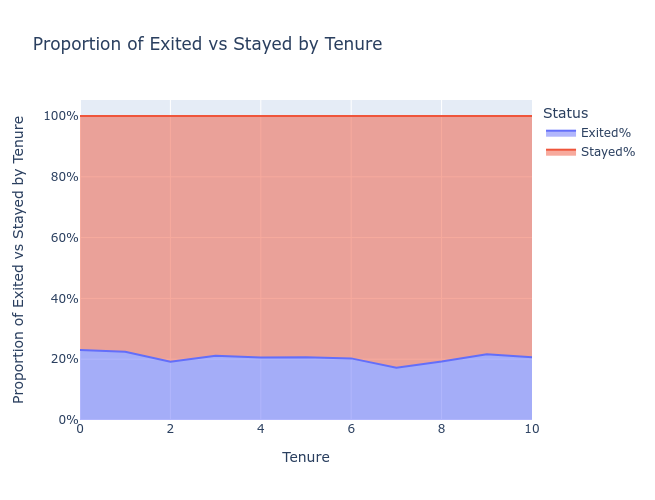

,count,Exited,Stayed,Exited%,Stayed%
Tenure,,,,,
2,1048,201,847,0.191794,0.808206
1,1035,232,803,0.224155,0.775845
7,1028,177,851,0.172179,0.827821
8,1025,197,828,0.192195,0.807805
5,1012,209,803,0.206522,0.793478
3,1009,213,796,0.211100,0.788900
4,989,203,786,0.205258,0.794742
9,984,213,771,0.216463,0.783537
6,967,196,771,0.202689,0.797311


In [12]:
tenure_counting = count_exited(X_raw, Y, 'Tenure')
plot_counting('Proporção de saída por tempo de conta', tenure_counting, format='area')

Esse fator parece ter uma variabilidade muito baixa. Vale a pergunta: ele é explicativo? Vamos fazer um teste, gerando regressões com e sem esse fator:

In [13]:
 def compare_factor_relevance(X, Y, factors):
    X = sm.add_constant(X)
    X_prime = X.drop(factors, axis=1)
    return compare_models(X, X_prime, Y, Y)

compare_factor_relevance(X, Y, ['Tenure'])

ValueError: endog must be in the unit interval.

In [ ]:
tenure_counting['Exited'].std()

# Análise de pré-requisitos

Para avaliar como melhor utilizar essas variáveis, vamos executar dois procedimentos:

- verificar se a base está balanceada e, se não, balanceá-la; e
- verificar os pré-requisitos dos fatores para regressão logística.

### Balanceamento da base

Verifiquemos se a base está balanceada:

In [ ]:
def show_dataset_balance(df):
    counts = df.value_counts()
    counts_df = pd.DataFrame(dict(counts=counts), index=counts.index)
    counts_graph = px.pie(
        title='Proporção de clientes atuais e evadidos',
        values=counts_df['counts'],
        names=['Atuais', 'Evadidos']
    )
    counts_graph.show()
    return counts_df

show_dataset_balance(Y)

Claramente, temos cinco clientes que não saíram para cada cliente que saiu. Isso é desbalanceado, então vamos balancear a base utilizndo [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html).

In [ ]:
from imblearn.over_sampling import SMOTENC

smotenc = SMOTENC(categorical_features=[X.columns.get_loc(f) for f in categorical_factors], random_state=42)
X, Y = smotenc.fit_resample(X, Y)

show_dataset_balance(Y)

Com a base balanceada, podemos prosseguir para analisar os pré-requisitos da regressão logística:
- ausência de colinearidade entre fatoreds;
- linearidade entre fatores e o logit das razões de chances.

### Colinearidade

A colinearidade pode ser verificada utilizando o [fator de inflação de variância](https://www.datacamp.com/pt/tutorial/variance-inflation-factor).

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Since VIF is calculated from R^2, we will need to do a regression
# and thus we need the constant column for the intercept.
X = sm.add_constant(X)
# Enconding categorical values
X = pd.get_dummies(X, columns=categorical_factors, drop_first=True, dtype=int)

In [ ]:
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif[vif['feature'] != 'const']

Como todos os valores estão bem próximos de 1, é razoável assumir que nenhum campo tem alta colinearidade, então podemos escolher quaisquer uns deles.

## Linearidade com o logit da probabilidade

Outro pré-requisito para regressão logística é uma relação quase linear entre os fatores e o log da razão de chance (i.e. a logit da probabilidade):

$$
X_1, X_2, ..., X_n \sim_{linear} Y
$$

Para verificar isso, vamos utilizar o [teste de Box-Tidwell](https://archive.org/details/logisticregressi0000ocon/page/44/mode/2up?q=%22box-tidwell%22). Esses são os passos do teste:

1. selecione apenas as colunas dos fatores contínuos;
2. selecione apenas as linhas em que todos os valores são positivos (no nosso caso, desnecessário, pois todos já são positivos);
3. para cada coluna original, adicione outra com o log natural dela;
4. para cada coluna original, adicione outra (chamada de "interação") com o produto do valor original pelo log do valor original;
5. treinamos uma regressão logística com esse novo dataset.
6. verificamos os coeficientes: se algum coeficiente de alguma interação for grande, isso indica não-linearidade da coluna original correspondente.

Aqui executamos os passos:

In [ ]:
import numpy as np

numeric_columns = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

def box_tidwell(X, Y, output_column='Exited', columns=numeric_factors):
    X = X[columns].copy()
    for c in X.columns:
        # We have many columns that are closer to the constant, so we
        # normalize colinearity with the constant
        X[c] = (X[c] - X[c].mean()) / X[c].std()
        X[c] = X[c] - X[c].min() + 1e-6
        # We add a very small positive constant to avoid zeros in the
        # values.
        X[f'{c}:interaction'] = X[c] * np.log(X[c].replace(0, 1e-6))
    X = sm.add_constant(X)
    model = sm.Logit(Y, X)
    result = model.fit()
    return result

def box_tidwell_multiple(X, Y, columns):
    bt_df = pd.DataFrame({
        'factor': [],
        'pvalue': []
    })
    for i, col in enumerate(columns):
        res = box_tidwell(X, Y, columns=[col])
        interaction = f'{col}:interaction'
        bt_df.loc[i] = [interaction, res.pvalues[interaction]]
    return bt_df

box_tidwell_multiple(X, Y, numeric_columns)

De todos os fatores, apenas salário estimado apresenta linearidade com o logit. Neste ponto, vale a pena olharmos para a relação entre os valores e o churn mais calmamente. Vamos plotar alguns histogramas dos valores:

In [ ]:
for col in numeric_columns:
    prop = df[col] / 
    fig = px.histogram(
        df,
        x=col,
        color='Exited',
        barmode='stack',
        title=f'Distribution of {col} by Exited Status',
        color_discrete_map={0: '#1f77b4', 1: '#ff7f0e'}  # optional: blue/orange
    )
    fig.update_layout(
        yaxis_title='Percentage',
        bargap=0.1
    )
    fig.show()


Podemos experimentar transformações para tentar encontrar linearidades.

In [ ]:
def box_tidwell_transform(X, Y, columns, f):
    X = X.copy()
    for c in columns:
        X[c] = f(X[c])
    return box_tidwell_multiple(X, Y, columns)

Comecemos considerando o logaritmo das propriedades:

In [ ]:
box_tidwell_transform(X, Y, numeric_columns, lambda v: np.log(v+1))

# Apêndice - Sandbox


In [ ]:
sm.add_constant(sm.add_constant(X['Age']))

In [ ]:


import numpy as np
import pandas as pd
import statsmodels.api as sm

def box_tidwell_test(X, y, columns, varbose=False):
    """
    Performs the Box–Tidwell test for linearity for each column in `columns`.
    Also tests if log(x) or x² transformation improves linearity.
    """
    results = []
    
    for col in columns:
        x = X[col].copy()
        # Add a small offset to avoid log(0)
        x = x + 1e-6
        
        # Build design matrix: original + interaction
        data = pd.DataFrame({
            col: x,
            f'{col}:interaction': x * np.log(x)
        })
        data = sm.add_constant(data)
        
        try:
            model = sm.Logit(y, data)
            result = model.fit(disp=0)
            p_interaction = result.pvalues[f'{col}:interaction']
        except Exception as e:
            p_interaction = np.nan
            if verbose:
                print(f"[WARN] {col} failed: {e}")
        
        # Try log transform
        try:
            x_log = np.log(x)
            data_log = sm.add_constant(x_log)
            res_log = sm.Logit(y, data_log).fit(disp=0)
            log_ll = res_log.llf
        except Exception:
            log_ll = np.nan
        
        # Try quadratic transform
        try:
            x_quad = x ** 2
            data_quad = sm.add_constant(x_quad)
            res_quad = sm.Logit(y, data_quad).fit(disp=0)
            quad_ll = res_quad.llf
        except Exception:
            quad_ll = np.nan

        # Try cubic transform
        try:
            x_cube = x ** 2
            data_cube = sm.add_constant(x_cube)
            res_cube = sm.Logit(y, data_cube).fit(disp=0)
            cube_ll = res_cube.llf
        except Exception:
            cube_ll = np.nan

        # Try exponential transform
        try:
            x_exp = np.exp(x)
            data_exp = sm.add_constant(x_exp)
            res_exp = sm.Logit(y, data_cube).fit(disp=0)
            exp_ll = res_exp.llf
        except Exception:
            exp_ll = np.nan
        
        results.append({
            'Variable': col,
            'p(Box–Tidwell)': p_interaction,
            'Linearity holds?': 'Yes' if (p_interaction > 0.05) else 'No',
            'log(x) improves fit?': 'Yes' if (not np.isnan(log_ll) and log_ll > result.llf) else 'No',
            'x² improves fit?': 'Yes' if (not np.isnan(quad_ll) and quad_ll > result.llf) else 'No',
            'x3 improves fit?': 'Yes' if (not np.isnan(cube_ll) and cube_ll > result.llf) else 'No'
        })
    
    return pd.DataFrame(results)



In [ ]:
A[~A['Age'].isin(range(21, 81))]